In [147]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# Implementation of Naive Baiyes from scratch
# Naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem
# with strong (naive) independence assumptions between the features 

In [113]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

def naive_bayes(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

In [49]:
def accuracy(y_true,y_pred):
    accuracy = np.sum(y_true==y_pred) / len(y_true)
    return accuracy

In [19]:
train  = pd.read_csv('D:/ML/comp/titanic/train.csv')
test = pd.read_csv('D:/ML/comp/titanic/test.csv')

In [20]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [22]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [23]:
#We observe Null values in Age and in Cabin features
#Thus we try to fill Age values with average values by categorizing types of people 
#into more distinct recognizable categories so that the average value will be close to the real values

train['Title'] = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test['Title'] = test['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
train['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [24]:
# Since we observe Mr , Miss , Mrs and Master are 4 predominant categories , we club the rest into a category called others
train['Title'] = train['Title'].apply(lambda x: x if x == 'Mr' or x == 'Master' or x == 'Mrs' or x == 'Miss' else 'Other')
test['Title'] = test['Title'].apply(lambda x: x if x == 'Mr' or x == 'Master' or x == 'Mrs' or x == 'Miss' else 'Other')
train['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Other      27
Name: Title, dtype: int64

In [25]:
for title in train['Title'].unique():
    print(f'Average age for title {title}: {train[train.Title == title].Age.mean()}')

#replacing with mean age
for title in train['Title'].unique():
    train.loc[train['Age'].isna() & (train['Title'] == title), 'Age'] = train[train['Title'] == title]['Age'].mean()
    test.loc[test['Age'].isna() & (test['Title'] == title), 'Age'] = test[test['Title'] == title]['Age'].mean()

Average age for title Mr: 32.368090452261306
Average age for title Mrs: 35.898148148148145
Average age for title Miss: 21.773972602739725
Average age for title Master: 4.574166666666667
Average age for title Other: 42.38461538461539


In [75]:
train['noCabin'] = train['Cabin'].isnull().astype(int)
test['noCabin'] = test['Cabin'].isnull().astype(int)
train['Pclass'].value_counts()
train.groupby(['noCabin'])['Survived'].mean()

train['numeric_ticket'] = train['Ticket'].apply(lambda x: 1 if x.isnumeric() else 0)

train['Num_Embarked'] = train['Embarked'].apply(lambda x: 0 if x=='S' else(1 if x=='C' else 2))

train['Num_title'] = train['Title'].apply(lambda x: 0 if x=='Mr' else(1 if x=='Mrs' else(2 if x=='Miss' else(3 if x=='Master' else 4))))


In [76]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,noCabin,numeric_ticket,Num_Embarked,Num_title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.2500,NaN,S,Mr,1,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,PC 17599,71.2833,C85,C,Mrs,0,0,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,0,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,113803,53.1000,C123,S,Mrs,0,1,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.0500,NaN,S,Mr,1,1,0,0
5,6,0,3,"Moran, Mr. James",male,32.36809,0,0,330877,8.4583,NaN,Q,Mr,1,1,2,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00000,0,0,17463,51.8625,E46,S,Mr,0,1,0,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00000,3,1,349909,21.0750,NaN,S,Master,1,1,0,3
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00000,0,2,347742,11.1333,NaN,S,Mrs,1,1,0,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00000,1,0,237736,30.0708,NaN,C,Mrs,1,1,1,1


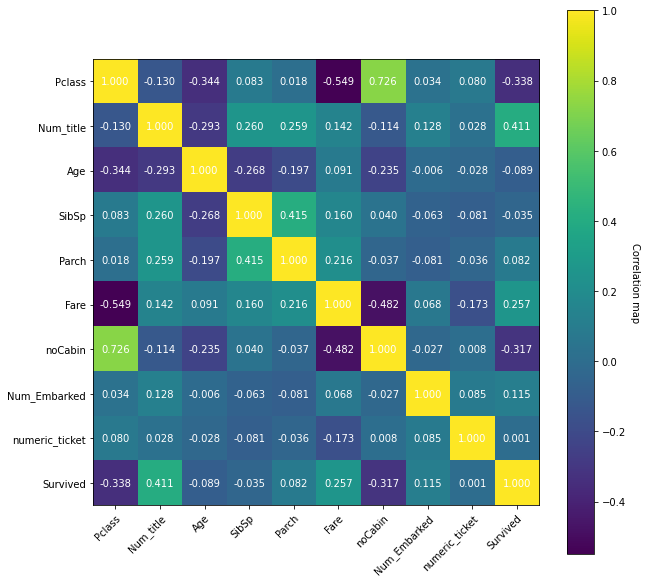

In [153]:
features = ['Pclass', 'Num_title', 'Age', 'SibSp', 'Parch', 'Fare', 'noCabin', 'Num_Embarked','numeric_ticket' , 'Survived']
fig, ax = plt.subplots(figsize=(10,10)) 
im = ax.imshow(train[features].corr())
ax.set_xticks(np.arange(len(features)), labels=features)
ax.set_yticks(np.arange(len(features)), labels=features)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax) 
cbar.ax.set_ylabel("Correlation map", rotation=-90, va="bottom")

corr_mat = np.array(train[features].corr())
for i in range(len(features)):
    for j in range(len(features)):
        text = ax.text(j, i,"{:.3f}".format(corr_mat[i,j]) ,ha="center", va="center", color="w")

In [125]:
training_data = train[features].sample(frac=0.35, random_state=41)
testing_data = train[features].drop(training_data.index)


X_test = testing_data.iloc[:,:-1].values
Y_test = testing_data.iloc[:,-1].values

Y_pred = naive_bayes(training_data[features], X=X_test , Y="Survived")

print("Naive Bayes Accuracy: ", accuracy(Y_test,Y_pred))


Naive Bayes Accuracy:  0.7495682210708118


In [142]:
X_train = training_data[features].iloc[:,:-1].values
Y_train = training_data[features].iloc[:,-1].values

from collections import Counter
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))


class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_idx = np.argsort(distances)[: self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_neighbor_labels = [self.y_train[i] for i in k_idx]
        # return the most common class label
        most_common = Counter(k_neighbor_labels).most_common(1)
        return most_common[0][0]

for k in range(4,9):
    clf = KNN(k)
    clf.fit(X_train,Y_train)
    predictions = clf.predict(X_test)
    accuracy = np.sum(Y_test == predictions) / len(Y_test)
    print('Accuracy of KNN with neighbours k='+str(k)+' is '+str(accuracy))

Accuracy of KNN with neighbours k=4 is 0.694300518134715
Accuracy of KNN with neighbours k=5 is 0.696027633851468
Accuracy of KNN with neighbours k=6 is 0.6994818652849741
Accuracy of KNN with neighbours k=7 is 0.697754749568221
Accuracy of KNN with neighbours k=8 is 0.6925734024179621
